<a href="https://colab.research.google.com/github/alastra32/DS-Unit-2-Regression-Classification/blob/master/module3/assignment_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`) using a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do exploratory visualizations with Seaborn.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a linear regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way (without an excessive amount of formulas or academic pre-requisites).
(That book is good regardless of whether your cultural worldview is inferential statistics or predictive machine learning)
- [ ] Read Leo Breiman's paper, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

In [1]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module3')

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.0.0)
Requirement already up-to-date: pandas-profiling in /usr/local/lib/python3.6/dist-packages (2.3.0)
Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.1.1)
Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification
 * branch            master     -> FETCH_HEAD
Already up to date.


In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

Instead, predict property sales prices for One Family Dwellings (BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS') using a subset of the data where the sale price was more than $100 thousand and less than $2 million.

In [4]:
df.head()

BOROUGH             NEIGHBORHOOD  ... SALE_PRICE   SALE_DATE
0        1                  CHELSEA  ...          0  01/01/2019
1        1                  FASHION  ...          0  01/01/2019
2        1                  FASHION  ...          0  01/01/2019
3        1   GREENWICH VILLAGE-WEST  ...          0  01/01/2019
4        1  UPPER EAST SIDE (59-79)  ...          0  01/01/2019

[5 rows x 21 columns]

In [5]:
df=df[df['BUILDING_CLASS_CATEGORY']=='01 ONE FAMILY DWELLINGS']
df=df[(df['SALE_PRICE'] >= 100000) & (df['SALE_PRICE'] <= 2000000)]
df.shape

(3164, 21)

 Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.

In [6]:
# Convert to datetime and look at the date range
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True)
df['SALE_DATE'].describe()

count                    3164
unique                     91
top       2019-01-31 00:00:00
freq                       78
first     2019-01-01 00:00:00
last      2019-04-30 00:00:00
Name: SALE_DATE, dtype: object

In [7]:

df['SALE_DATE'].dt.month.value_counts()


1    952
3    802
2    763
4    647
Name: SALE_DATE, dtype: int64

In [8]:
df.isna().sum()

BOROUGH                              0
NEIGHBORHOOD                         0
BUILDING_CLASS_CATEGORY              0
TAX_CLASS_AT_PRESENT                 0
BLOCK                                0
LOT                                  0
EASE-MENT                         3164
BUILDING_CLASS_AT_PRESENT            0
ADDRESS                              0
APARTMENT_NUMBER                  3163
ZIP_CODE                             0
RESIDENTIAL_UNITS                    0
COMMERCIAL_UNITS                     0
TOTAL_UNITS                          0
LAND_SQUARE_FEET                     0
GROSS_SQUARE_FEET                    0
YEAR_BUILT                           0
TAX_CLASS_AT_TIME_OF_SALE            0
BUILDING_CLASS_AT_TIME_OF_SALE       0
SALE_PRICE                           0
SALE_DATE                            0
dtype: int64

In [0]:


#filling NAN's 
df['EASE-MENT'] = df['EASE-MENT'].fillna(0)
df['APARTMENT_NUMBER'] = df['APARTMENT_NUMBER'].fillna(' ')

In [10]:
df.isna().sum()

BOROUGH                           0
NEIGHBORHOOD                      0
BUILDING_CLASS_CATEGORY           0
TAX_CLASS_AT_PRESENT              0
BLOCK                             0
LOT                               0
EASE-MENT                         0
BUILDING_CLASS_AT_PRESENT         0
ADDRESS                           0
APARTMENT_NUMBER                  0
ZIP_CODE                          0
RESIDENTIAL_UNITS                 0
COMMERCIAL_UNITS                  0
TOTAL_UNITS                       0
LAND_SQUARE_FEET                  0
GROSS_SQUARE_FEET                 0
YEAR_BUILT                        0
TAX_CLASS_AT_TIME_OF_SALE         0
BUILDING_CLASS_AT_TIME_OF_SALE    0
SALE_PRICE                        0
SALE_DATE                         0
dtype: int64

In [11]:
df.profile_report()

In [12]:
cutoff = pd.to_datetime('2019-04-01')
train = df[df.SALE_DATE < cutoff]
test = df[df.SALE_DATE >= cutoff]
train.shape, test.shape

((2517, 21), (647, 21))

Do exploratory visualizations with Seaborn.

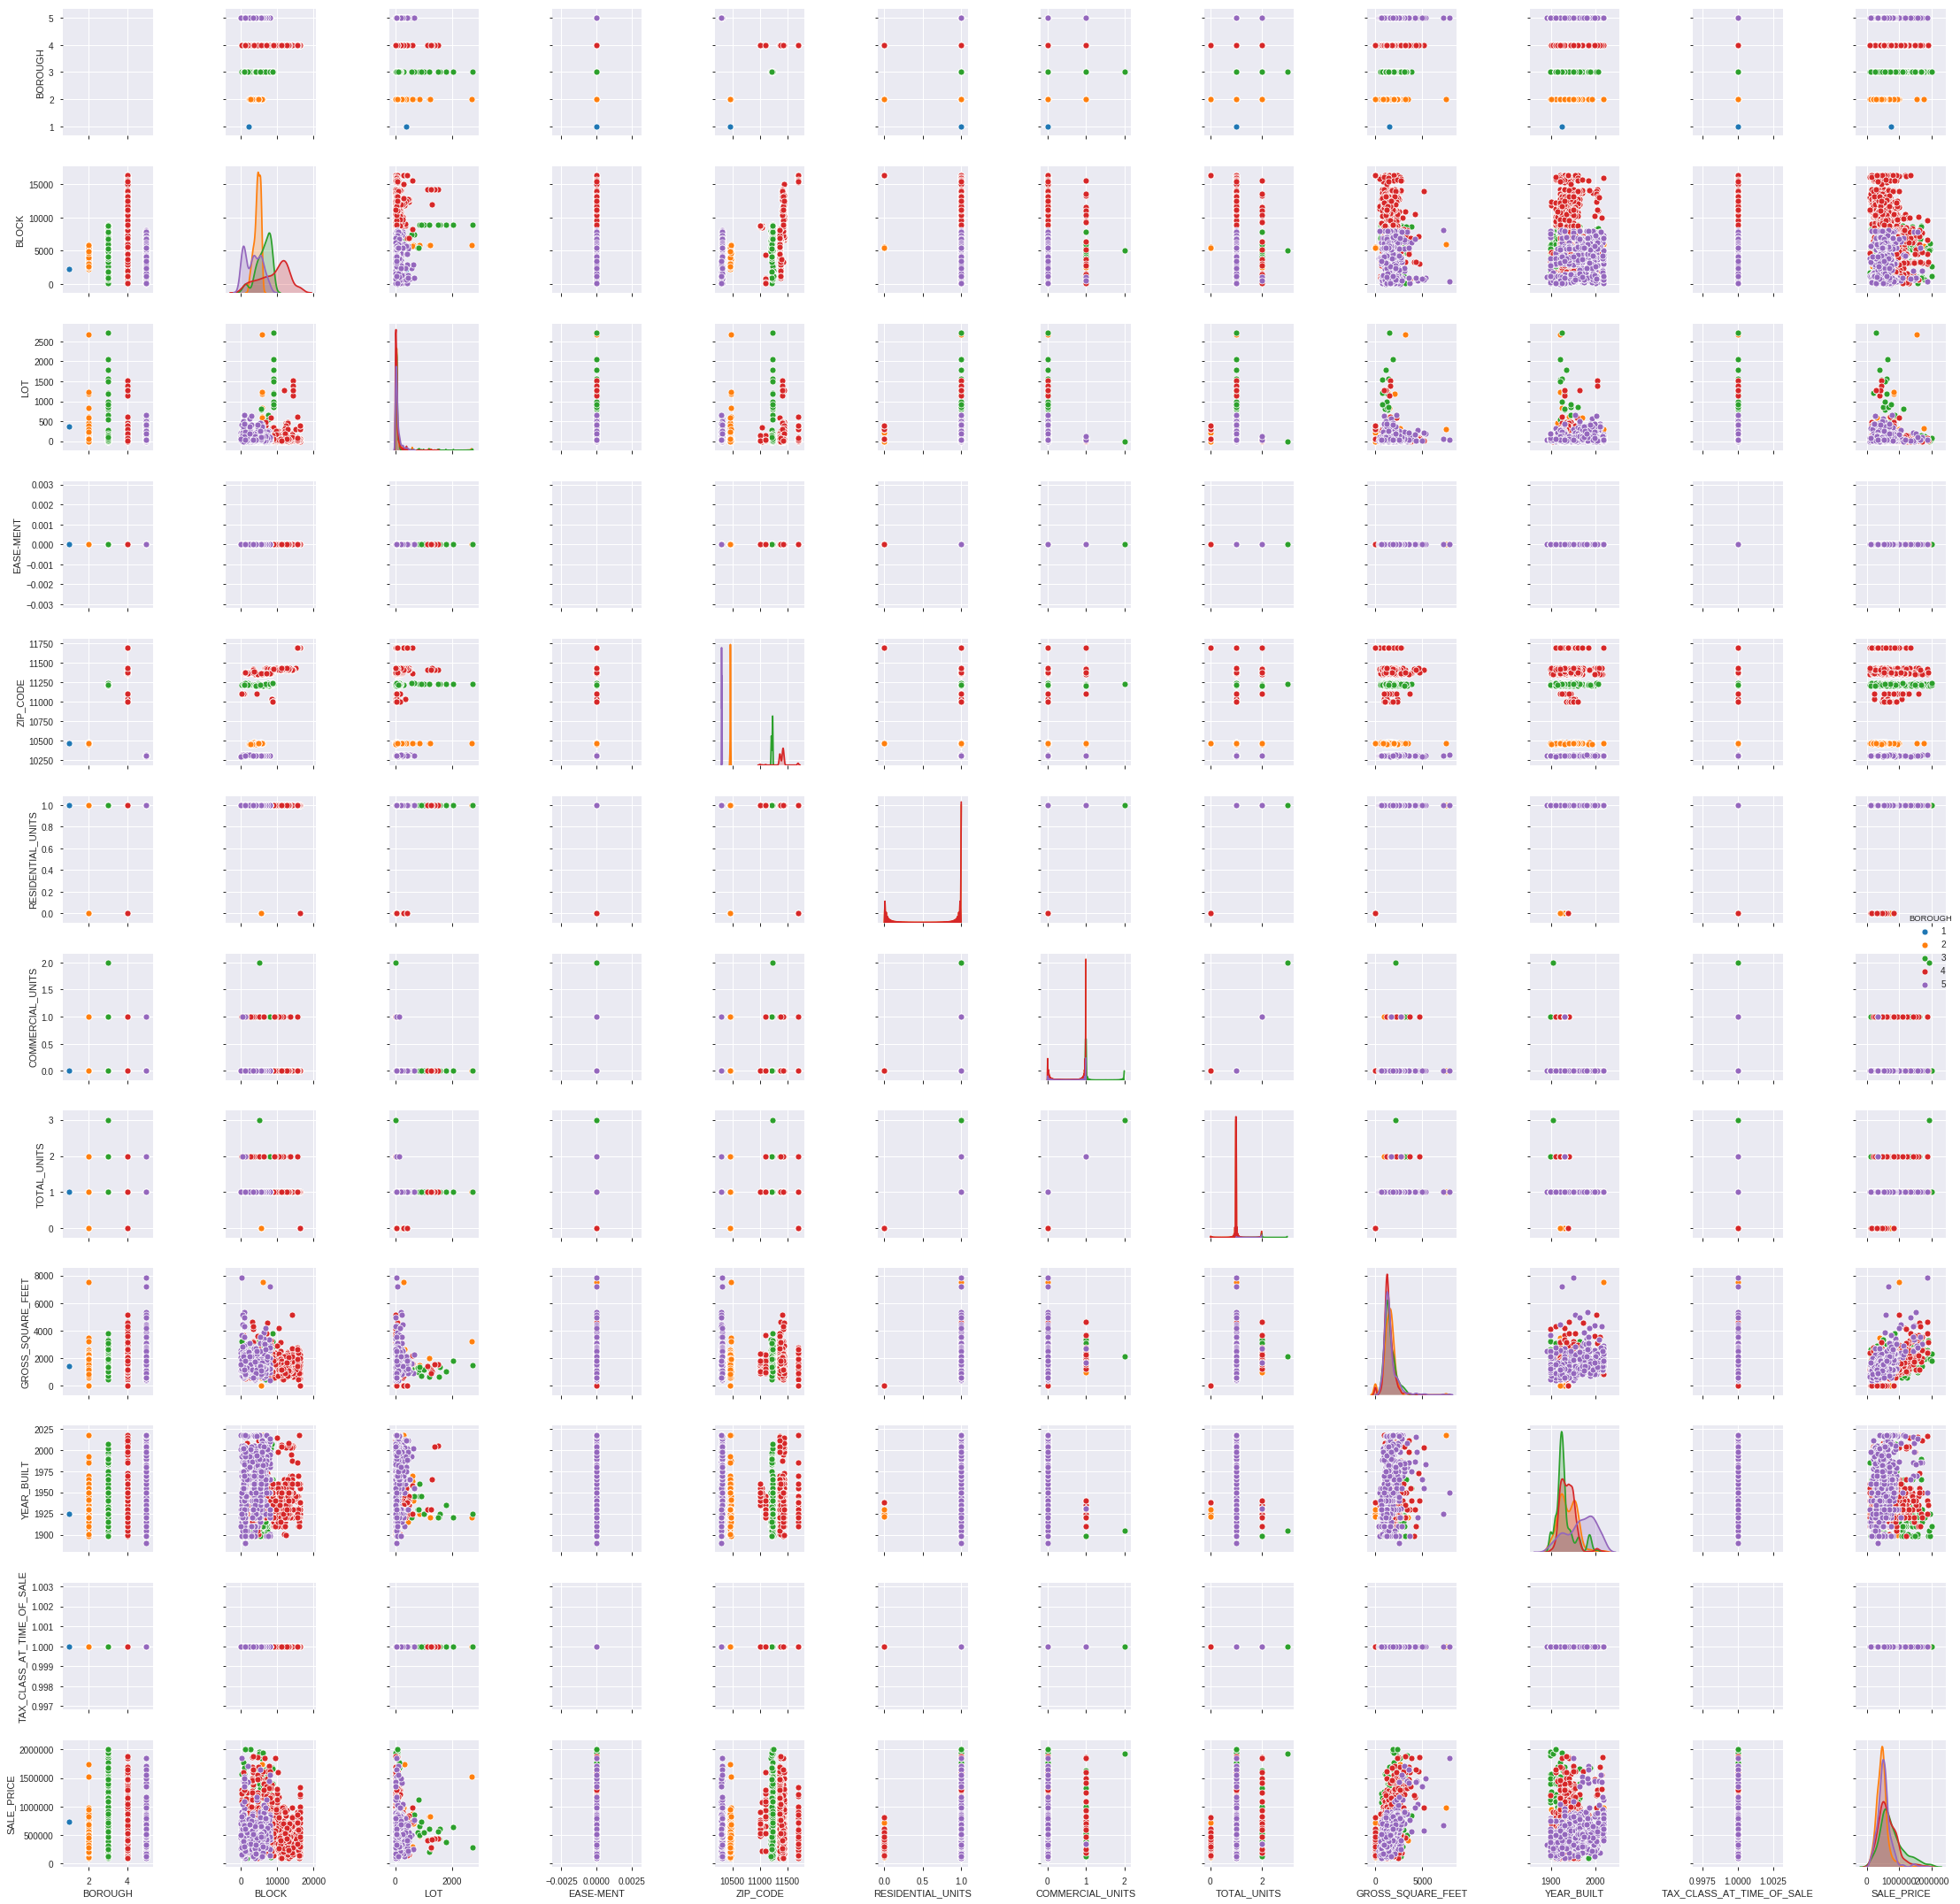

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(train,hue='BOROUGH');
plt.tight_layout()


Do one-hot encoding of categorical features.

In [14]:
def engineer_features(df):
    #What's the neighborhood, based on address or latitude and longitude?
    borough=pd.get_dummies(df['BOROUGH'], prefix = 'BOROUGH')
    for col in borough:
        df[col] = borough[col]
  

    return df

df = engineer_features(df)

df.shape   

(3164, 26)

In [15]:
cutoff = pd.to_datetime('2019-04-01')
train = df[df.SALE_DATE < cutoff]
test = df[df.SALE_DATE >= cutoff]
train.shape, test.shape

((2517, 26), (647, 26))

In [16]:
train.head()

BOROUGH          NEIGHBORHOOD  ... BOROUGH_4 BOROUGH_5
44         3   OCEAN PARKWAY-NORTH  ...         0         0
61         4        QUEENS VILLAGE  ...         1         0
78         2  PELHAM PARKWAY SOUTH  ...         0         0
108        3      FLATBUSH-CENTRAL  ...         0         0
111        3         FLATBUSH-EAST  ...         0         0

[5 rows x 26 columns]

In [17]:
train.describe(exclude='number')

NEIGHBORHOOD  ...            SALE_DATE
count             2517  ...                 2517
unique             178  ...                   68
top     FLUSHING-NORTH  ...  2019-01-31 00:00:00
freq                78  ...                   78
first              NaN  ...  2019-01-01 00:00:00
last               NaN  ...  2019-03-30 00:00:00

[6 rows x 9 columns]

In [18]:
train['BUILDING_CLASS_AT_TIME_OF_SALE'].nunique()

11

 Do feature selection with SelectKBest.


In [19]:
train_subset = train.select_dtypes('number').dropna(axis='columns')
test_subset  = test.select_dtypes('number').dropna(axis='columns')

target = 'SALE_PRICE'
features = train_subset.columns.drop(target)
X_train = train_subset[features]
y_train = train_subset[target]
X_test  = test_subset[features]
y_test  = test_subset[target]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2517, 16), (2517,), (647, 16), (647,))

In [20]:
#Select the 8 features that best correlate to the target
from sklearn.feature_selection import f_regression, SelectKBest


selector = SelectKBest(score_func=f_regression, k = 8)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

X_train_selected.shape, X_test_selected.shape

((2517, 8), (647, 8))

In [21]:
# Which features were selected?



all_names = X_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)


Features selected:
BLOCK
ZIP_CODE
COMMERCIAL_UNITS
TOTAL_UNITS
GROSS_SQUARE_FEET
BOROUGH_2
BOROUGH_3
BOROUGH_5


 Fit a linear regression model with multiple features.


 Get mean absolute error for the test set.

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,r2_score

model = LinearRegression()
model.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print(f'Train MAE: ${mae:,.0f}')
print(f'Train R^2 : {r2:,.4f}')

Train MAE: $169,357
Train R^2 : 0.3450


In [23]:
#Select the 16 features that best correlate to the target
from sklearn.feature_selection import f_regression, SelectKBest


selector = SelectKBest(score_func=f_regression, k = 16)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

X_train_selected.shape, X_test_selected.shape

((2517, 16), (647, 16))

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,r2_score

model = LinearRegression()
model.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print(f'Train MAE: ${mae:,.0f}')
print(f'Train R^2 : {r2:,.4f}')

Train MAE: $169,465
Train R^2 : 0.3432


Further Test New Hot Coding

In [25]:
def engineer_features(df):
    #What's the neighborhood, based on address or latitude and longitude?
    borough=pd.get_dummies(df['BOROUGH'], prefix = 'BOROUGH')
    for col in borough:
        df[col] = borough[col]
    buildclass=pd.get_dummies(df['BUILDING_CLASS_AT_TIME_OF_SALE'], prefix = 'BUILDING_CLASS')
    for col in buildclass:
        df[col] = buildclass[col]

    return df

df = engineer_features(df)

df.shape   

(3164, 37)

In [26]:
cutoff = pd.to_datetime('2019-04-01')
train = df[df.SALE_DATE < cutoff]
test = df[df.SALE_DATE >= cutoff]
train.shape, test.shape

((2517, 37), (647, 37))

In [27]:
train_subset = train.select_dtypes('number').dropna(axis='columns')
test_subset  = test.select_dtypes('number').dropna(axis='columns')

target = 'SALE_PRICE'
features = train_subset.columns.drop(target)
X_train = train_subset[features]
y_train = train_subset[target]
X_test  = test_subset[features]
y_test  = test_subset[target]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2517, 27), (2517,), (647, 27), (647,))

In [28]:
#Select the 10 features that best correlate to the target
from sklearn.feature_selection import f_regression, SelectKBest


selector = SelectKBest(score_func=f_regression, k = 10)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

X_train_selected.shape, X_test_selected.shape

((2517, 10), (647, 10))

In [29]:
# Which features were selected?

all_names = X_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)


Features selected:
BLOCK
ZIP_CODE
COMMERCIAL_UNITS
TOTAL_UNITS
GROSS_SQUARE_FEET
BOROUGH_2
BOROUGH_3
BOROUGH_5
BUILDING_CLASS_A3
BUILDING_CLASS_A5


In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,r2_score

model = LinearRegression()
model.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print(f'Train MAE: ${mae:,.0f}')
print(f'Train R^2 : {r2:,.4f}')

Train MAE: $167,407
Train R^2 : 0.3606


In [31]:
#Select the 25 features that best correlate to the target
from sklearn.feature_selection import f_regression, SelectKBest


selector = SelectKBest(score_func=f_regression, k = 25)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

X_train_selected.shape, X_test_selected.shape

((2517, 25), (647, 25))

In [32]:
# Which features were selected?

all_names = X_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)

Features selected:
BOROUGH
BLOCK
LOT
ZIP_CODE
RESIDENTIAL_UNITS
COMMERCIAL_UNITS
TOTAL_UNITS
GROSS_SQUARE_FEET
YEAR_BUILT
BOROUGH_1
BOROUGH_2
BOROUGH_3
BOROUGH_4
BOROUGH_5
BUILDING_CLASS_A0
BUILDING_CLASS_A1
BUILDING_CLASS_A2
BUILDING_CLASS_A3
BUILDING_CLASS_A4
BUILDING_CLASS_A5
BUILDING_CLASS_A6
BUILDING_CLASS_A8
BUILDING_CLASS_A9
BUILDING_CLASS_S0
BUILDING_CLASS_S1


In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,r2_score

model = LinearRegression()
model.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print(f'Train MAE: ${mae:,.0f}')
print(f'Train R^2 : {r2:,.4f}')

Train MAE: $165,688
Train R^2 : 0.3657
